 ## Master notebook

In [1]:
import os
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from scripts.models import (
    cheng_model,
    frank_model,
    ordloss_model
)
from scripts.data_preparation import merge_station_data
from scripts.metrics import report_performance, plot_confusion_matrix

from fastai import *
from fastai.tabular.all import *

from torch.nn import ReLU, LeakyReLU

import pickle

In [4]:
df = merge_station_data(engineer_date=True)

# Save cleaned data
df.to_csv('./data/cleaned_data.csv', index=False)

['Processed data for station: KLO3']
['Processed data for station: ANV3']
['Processed data for station: GAN2']
['Processed data for station: DAV3']


In [5]:
((df.dangerLevel.value_counts() / len(df.index)) * 100).sort_index()

1.0    20.768653
2.0    47.008012
3.0    30.821232
4.0     1.402103
Name: dangerLevel, dtype: float64

## Baseline

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
# Process
df_ = merge_station_data(engineer_date=False, verbose=False)
bools = df_.columns[df_.dtypes == bool]
df_.loc[:, bools] = df_[bools].astype('category')
#df_ = df_.drop(columns=list(bools) + ["station"])
df_ = pd.get_dummies(df_)

In [8]:
# Split X, y, train, test
y = df_['dangerLevel']
X = df_.drop(columns=["dangerLevel"])
mask = df_.date < '2015-01-01'
X.drop(columns="date", inplace=True)
X_train = X[mask]
y_train = y[mask]
# Normalize
mean_train = X_train.mean()
std_train = X_train.std()
X_train = (X_train - mean_train) / std_train

In [9]:
model = LogisticRegression(max_iter=1000, class_weight="balanced").fit(X_train, y_train)

In [10]:
X_test = (X[~mask] - mean_train) / std_train
y_true_bench = y[~mask]

In [11]:
y_pred_bench = pd.Series(model.predict(X_test))
y_pred_bench.value_counts()

2.0    727
3.0    655
1.0    607
4.0     45
dtype: int64

In [12]:
import sklearn.metrics as metrics
print(metrics.classification_report(y_pred_bench, y_true_bench))
print(f"Balanced accuracy: {metrics.balanced_accuracy_score(y_pred_bench, y_true_bench):.4f}")

              precision    recall  f1-score   support

         1.0       0.89      0.89      0.89       607
         2.0       0.76      0.80      0.78       727
         3.0       0.81      0.77      0.79       655
         4.0       0.16      0.18      0.17        45

    accuracy                           0.80      2034
   macro avg       0.66      0.66      0.66      2034
weighted avg       0.80      0.80      0.80      2034

Balanced accuracy: 0.6579


In [13]:
report_performance(y_pred=y_pred_bench, y_true=y_true_bench, approach="Benchmark")

,Benchmark
Prec_1.0,0.890
Prec_2.0,0.796
Prec_3.0,0.768
Prec_4.0,0.178
Rec_1.0,0.893
Rec_2.0,0.760
Rec_3.0,0.814
Rec_4.0,0.163
MMSE,0.429
MMAD,0.371


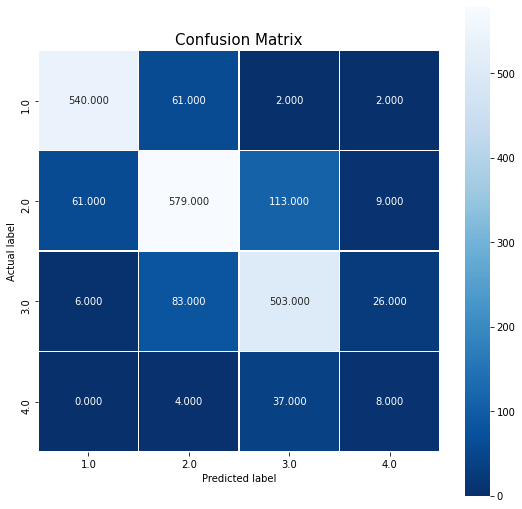

In [14]:
plot_confusion_matrix(y_true_bench, y_pred_bench)

## Cheng approach

In [15]:
opt_params_cheng = pickle.load(open( "./cross_validation/cheng/opt_par_cv2.p", "rb" ))

In [16]:
opt_params_cheng

{'layers': [100, 100],
 'lr': 0.01,
 'actfn': LeakyReLU(negative_slope=0.01),
 'bs': 64,
 'epochs': 15,
 'engineer_date': True}

In [17]:
def random_seed(seed_value, use_cuda):
    """
    Set seed for before fitting.
    
    Source: https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/27v
    """
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

Note: rerun the seed before training

In [18]:
random_seed(1, True)

['Processed data for station: KLO3']
['Processed data for station: ANV3']
['Processed data for station: GAN2']
['Processed data for station: DAV3']


epoch,train_loss,valid_loss,f1_score,time
0,0.244269,0.161250,0.928309,00:03
1,0.155260,0.120174,0.954545,00:02
2,0.131539,0.121145,0.954503,00:02
3,0.109110,0.115084,0.961858,00:02
4,0.092363,0.117885,0.958527,00:02
5,0.076338,0.116672,0.959219,00:03
6,0.062734,0.117692,0.959159,00:02


2034


              precision    recall  f1-score   support

         1.0       0.96      0.91      0.94       605
         2.0       0.86      0.88      0.87       762
         3.0       0.86      0.90      0.88       618
         4.0       0.83      0.59      0.69        49

    accuracy                           0.89      2034
   macro avg       0.88      0.82      0.84      2034
weighted avg       0.89      0.89      0.89      2034


Macro-averaged mean squared error: 0.18255373824996468

Macro-averaged mean absolute error: 0.18091823048029979


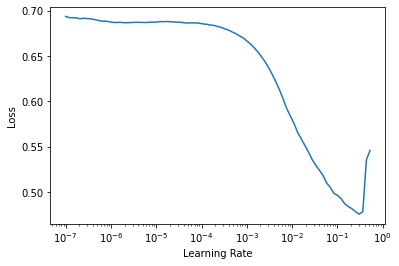

In [19]:
y_pred_cheng, y_true_cheng, learn = cheng_model.fit_and_predict(**{
     'layers': [100, 100],
     'lr': 0.01,
     'actfn': LeakyReLU(negative_slope=0.01),
     'bs': 64,
     'epochs': 7,
     'engineer_date': True,
})

In [20]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(25, 10)
    (1): Embedding(9, 5)
    (2): Embedding(33, 11)
    (3): Embedding(32, 11)
    (4): Embedding(8, 5)
    (5): Embedding(207, 32)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(314, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(410, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=410, out_features=100, bias=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): 

In [21]:
import io
import plotnine as pn

In [42]:
s = io.StringIO(
"""
Epoch Train Test
0 0.244269 0.161250
1 0.155260 0.120174
2 0.131539 0.121145
3 0.109110 0.115084
4 0.092363 0.117885
5 0.076338 0.116672
6 0.062734 0.117692
"""
)

In [43]:
loss_tbl = pd.read_csv(s, sep=" ")

In [44]:
loss_tbl

,Epoch,Train,Test
0,0,0.244269,0.161250
1,1,0.155260,0.120174
2,2,0.131539,0.121145
3,3,0.109110,0.115084
4,4,0.092363,0.117885
5,5,0.076338,0.116672
6,6,0.062734,0.117692


In [45]:
loss_tbl_melt = pd.melt(loss_tbl, value_vars=["Train", "Test"], id_vars=["Epoch"])
loss_tbl_melt.loc[:, "Epoch"] = loss_tbl_melt.loc[:, "Epoch"].astype("category")

In [46]:
loss_tbl_melt

,Epoch,variable,value
0,0,Train,0.244269
1,1,Train,0.155260
2,2,Train,0.131539
3,3,Train,0.109110
4,4,Train,0.092363
5,5,Train,0.076338
6,6,Train,0.062734
7,0,Test,0.161250
8,1,Test,0.120174
9,2,Test,0.121145


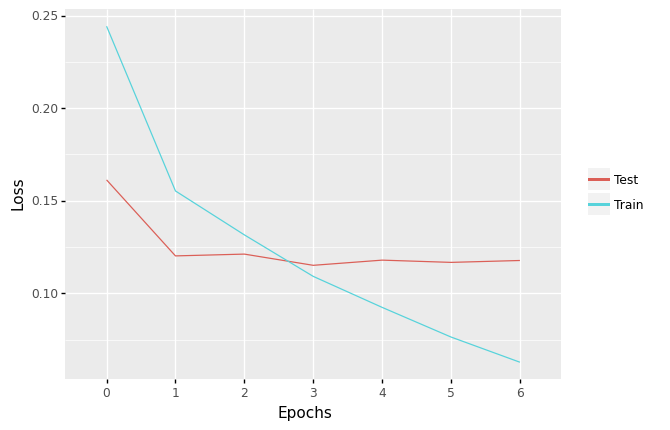

<ggplot: (8794734677845)>

In [47]:
(pn.ggplot(loss_tbl_melt, pn.aes(x="Epoch", y="value", group="variable", color="variable"))
 + pn.geom_line()
 + pn.ylab("Loss")
 + pn.xlab("Epochs")
 + pn.theme(legend_title = pn.element_blank()))

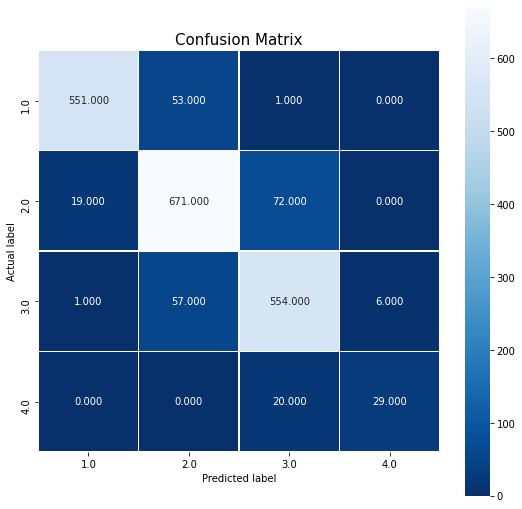

In [48]:
plot_confusion_matrix(y_true_cheng, y_pred_cheng)

## OrdLoss Approach

In [29]:
opt_params = pickle.load( open( "./cross_validation/ordloss/opt_par_cv.p", "rb" ) )
opt_params

{'nodes': 5,
 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]),
 'epochs': 15,
 'batch_size': 2,
 'lr': 0.01,
 'start': -10,
 'end': 10,
 'pca': True,
 'dates': True}

Note: Rerun the data loading!

In [30]:
random_seed(1, True)

100%|██████████| 2977/2977 [00:04<00:00, 683.22it/s]


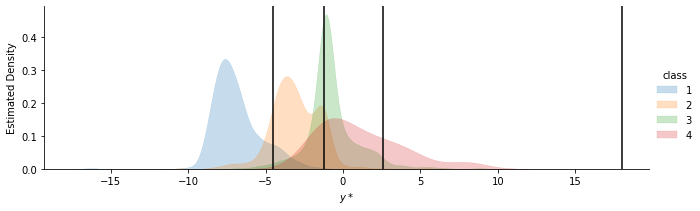

              precision    recall  f1-score   support

           1       0.83      0.91      0.87       605
           2       0.71      0.75      0.73       762
           3       0.78      0.67      0.72       618
           4       0.35      0.27      0.30        49

    accuracy                           0.76      2034
   macro avg       0.67      0.65      0.65      2034
weighted avg       0.76      0.76      0.76      2034

Balanced Accuracy:	0.648



In [31]:
y_pred_ordloss, y_true_ordloss = ordloss_model.fit_and_predict(df, opt_params)

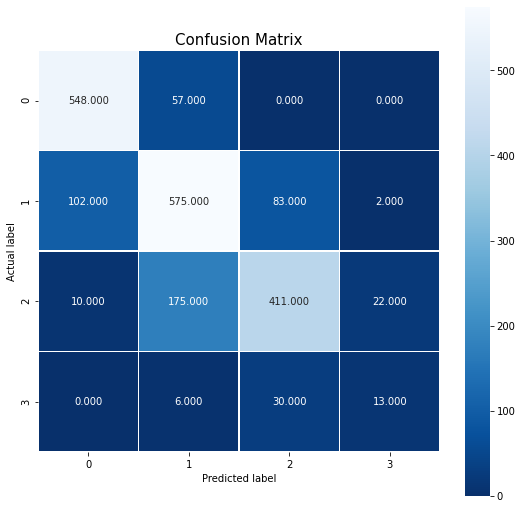

In [49]:
plot_confusion_matrix(y_true_ordloss, y_pred_ordloss)

## Frank et al. Approach

In [32]:
opt_params = pickle.load( open( "./cross_validation/frank/opt_par_cv.p", "rb" ) )
opt_params

{'classifier': ('xgb', 'logistic', 'tree'),
 'PCA': False,
 'drop_cat': True,
 'params': [{'scale_pos_weight': 1.0,
   'learning_rate': 0.1,
   'max_depth': 9,
   'gamma': 0.2,
   'colsample_bytree': 1.0,
   'verbosity': 0},
  {'max_iter': 1000, 'tol': 0.0001, 'class_weight': None, 'C': 2.0},
  {'class_weight': None,
   'min_samples_split': 8,
   'min_samples_leaf': 1,
   'max_depth': 6}]}

In [33]:
random_seed(1, True)

Drop_cat is set to true, dropping: ['station', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
P matrix:
  Non-positive: 576 (7.080%)
Balanced Accuracy:	0.673

Per Class Accuracy
1.0    0.883
2.0    0.823
3.0    0.783
4.0    0.204
dtype: float64

              precision    recall  f1-score   support

         1.0       0.94      0.88      0.91       605
         2.0       0.77      0.82      0.80       762
         3.0       0.78      0.78      0.78       618
         4.0       0.32      0.20      0.25        49

    accuracy                           0.81      2034
   macro avg       0.70      0.67      0.68      2034
weighted avg       0.81      0.81      0.81      2034


Macro-averaged mean squared error: 0.3971142543791533
Macro-averaged mean absolute error: 0.35024934688353027


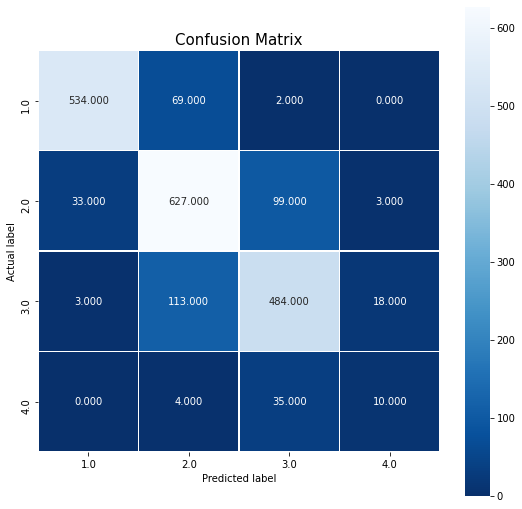

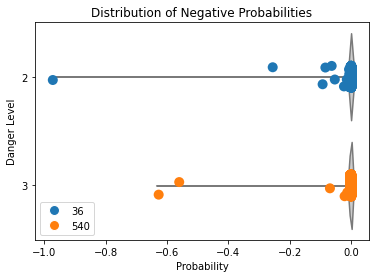

In [34]:
y_pred_frank, y_true_frank, clf = frank_model.fit_and_predict(df, **opt_params)

## Report performance of candidate models and baseline

In [39]:
predictions = [
    dict(y_pred=y_pred_bench.astype(int), y_true=y_true_bench.astype(int), approach="Benchmark"),
    dict(y_pred=y_pred_cheng, y_true=y_true_cheng, approach="Cheng"),
    dict(y_pred=y_pred_ordloss + 1, y_true=y_true_ordloss + 1, approach="OrdLoss"),
    dict(y_pred=y_pred_frank.astype(int), y_true=y_true_frank.astype(int), approach="Frank et al."),
]

In [40]:
perf = [report_performance(**d) for d in predictions]
tbl = pd.concat(perf, axis=1)

In [41]:
# Output for report
print(tbl.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Benchmark &  Cheng &  OrdLoss &  Frank et al. \\
\midrule
Prec\_1 &      0.890 &  0.965 &    0.830 &         0.937 \\
Prec\_2 &      0.796 &  0.859 &    0.707 &         0.771 \\
Prec\_3 &      0.768 &  0.856 &    0.784 &         0.781 \\
Prec\_4 &      0.178 &  0.829 &    0.351 &         0.323 \\
Rec\_1  &      0.893 &  0.911 &    0.906 &         0.883 \\
Rec\_2  &      0.760 &  0.881 &    0.755 &         0.823 \\
Rec\_3  &      0.814 &  0.896 &    0.665 &         0.783 \\
Rec\_4  &      0.163 &  0.592 &    0.265 &         0.204 \\
MMSE   &      0.429 &  0.183 &    0.458 &         0.397 \\
MMAD   &      0.371 &  0.181 &    0.388 &         0.350 \\
\bottomrule
\end{tabular}

